In [12]:
import pandas as pd
import os 
import random
import subprocess

import dask.dataframe as dd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2

In [2]:
snps_names = pd.read_csv('../key_files/var_pos_grenenet.csv')

import pickle
with open('../key_files/blocks_snpsid_dict.pkl', 'rb') as f:
    dict_blocks = pickle.load(f)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

snps_names = snps_names[snps_names['total_alleles05filter_firstgen'].notna()].reset_index(drop=True)

In [10]:
def calculate_genomic_inflation_factor(p_values):
    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)
    
    # Calculate lambda (genomic inflation factor)
    lambda_gif = np.median(chi_squared_stats) / chi2.ppf(0.5, 1)
    
    return lambda_gif

def adjust_p_values(p_values, lambda_gif):
    # Adjust the chi-squared values
    adjusted_chi_squared = -2 * np.log(p_values) / lambda_gif
    
    # Convert adjusted chi-squared values back to p-values
    adjusted_p_values = np.exp(-adjusted_chi_squared / 2)
    
    return adjusted_p_values

In [15]:
maf = pd.read_csv('../key_files/maf_all_samples_last_gen.csv')

In [3]:
#os.listdir('../binomial_regression_lastgen/')

In [18]:
biovar = 'bio1'  # bio12_binomial_reg_results_last_gen

In [28]:
biovars = [
 'bio2',
 'bio3',
 'bio4',
 'bio5',
 'bio6',
 'bio7',
 'bio8',
 'bio9',
 'bio10',
 'bio11',
 'bio13',
 'bio14',
 'bio15',
 'bio16',
 'bio17',
 'bio19']

In [29]:
for biovar in biovars:
    binomial_reg = pd.read_csv(f'../binomial_regression_lastgen/{biovar}_binomial_reg_results_last_gen.csv')
    
    binomial_reg['block'] = binomial_reg['snp_id'].map(reverse_mapping) 
    
    #binomial_reg['pos'] = binomial_reg['snp_id'].str.split('_').str[1].astype(int)
    
    # Example usage
    p_values = binomial_reg['pvalue']  # Example p-values
    lambda_gif = calculate_genomic_inflation_factor(p_values)
    
    adjusted_p_values = adjust_p_values(p_values, 5)
    
    binomial_reg['adj_pvalue'] = adjusted_p_values
    
    binomial_reg = pd.concat([binomial_reg, maf],axis=1)
    
    binomial_reg.columns = ['slope', 'pvalue', 'snp_id', 'block', 'adj_pvalue', 'MAF']
    
    binomial_reg.to_csv(f'../binomial_regression_lastgen/binomial_reg_lastgen_wmaf_{biovar}.csv',index=None)


/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered 

In [30]:
path = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza_last_gen/'

In [35]:
## create a dir 


# create sbatch files to submit on cedar server
shfiles = []
for biovar in biovars:
    seed = random.randint(1,100000000)
    file = f'wza_{biovar}.sh'
    cmd = f'python general_WZA_script_mod_polynomial_order7.py \
            --correlations ../binomial_regression_lastgen/binomial_reg_lastgen_wmaf_{biovar}.csv \
            --summary_stat pvalue \
            --window "block" \
            --output wza_binomial_regression_{biovar}_poly7.csv --sep ","'
    text = f'''#!/bin/bash
    #SBATCH --job-name=wza_{biovar}
    #SBATCH --time=1:00:00  # Time limit set to 4 days
    #SBATCH --ntasks=1
    #SBATCH --mem-per-cpu=30gb
    #SBATCH --output=wza_%j_{biovar}.out
    #SBATCH --mail-user=tbellagio@carnegiescience.edu
    #SBATCH --mail-type=FAIL
    
    module load python/3.11_conda
    conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake
    export LD_LIBRARY_PATH="/home/tbellagio/miniforge3/envs/run_baypass/lib:$LD_LIBRARY_PATH"
    cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza_last_gen
    {cmd}
    
    
    '''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

In [36]:
shfiles

['wza_bio2.sh',
 'wza_bio3.sh',
 'wza_bio4.sh',
 'wza_bio5.sh',
 'wza_bio6.sh',
 'wza_bio7.sh',
 'wza_bio8.sh',
 'wza_bio9.sh',
 'wza_bio10.sh',
 'wza_bio11.sh',
 'wza_bio13.sh',
 'wza_bio14.sh',
 'wza_bio15.sh',
 'wza_bio16.sh',
 'wza_bio17.sh',
 'wza_bio19.sh']

In [37]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 61759
Submitted batch job 61760
Submitted batch job 61761
Submitted batch job 61762
Submitted batch job 61763
Submitted batch job 61764
Submitted batch job 61765
Submitted batch job 61766
Submitted batch job 61767
Submitted batch job 61768
Submitted batch job 61769
Submitted batch job 61770
Submitted batch job 61771
Submitted batch job 61772
Submitted batch job 61773
Submitted batch job 61774


In [38]:
biovars[5]

'bio7'

In [ ]:
biovar=biovars[5]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [51]:
sns.set_context("talk")

In [63]:
biovars = ['bio1', 'bio2',
 'bio3',
 'bio4',
 'bio5',
 'bio6',
 'bio7',
 'bio8',
 'bio9',
 'bio10',
 'bio11',
 'bio12',
 'bio13',
 'bio14',
 'bio15',
 'bio16',
 'bio17',
 'bio18',
 'bio19']

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


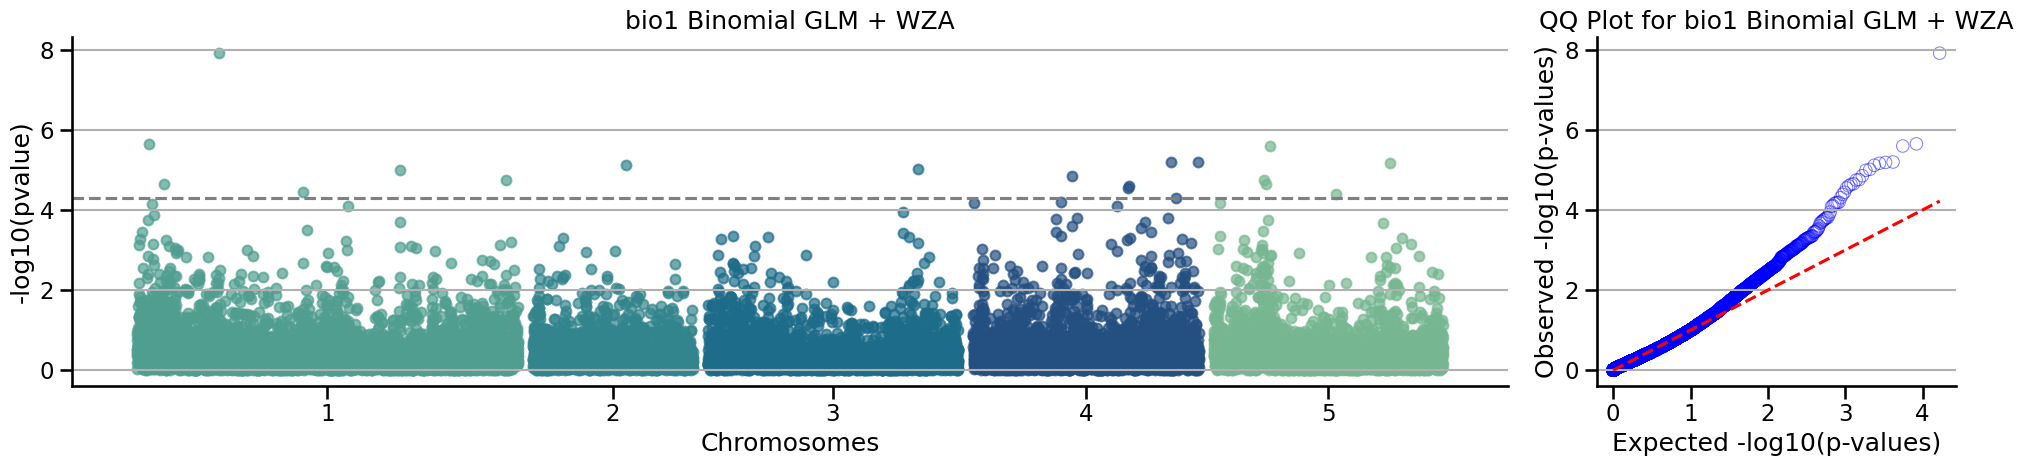

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


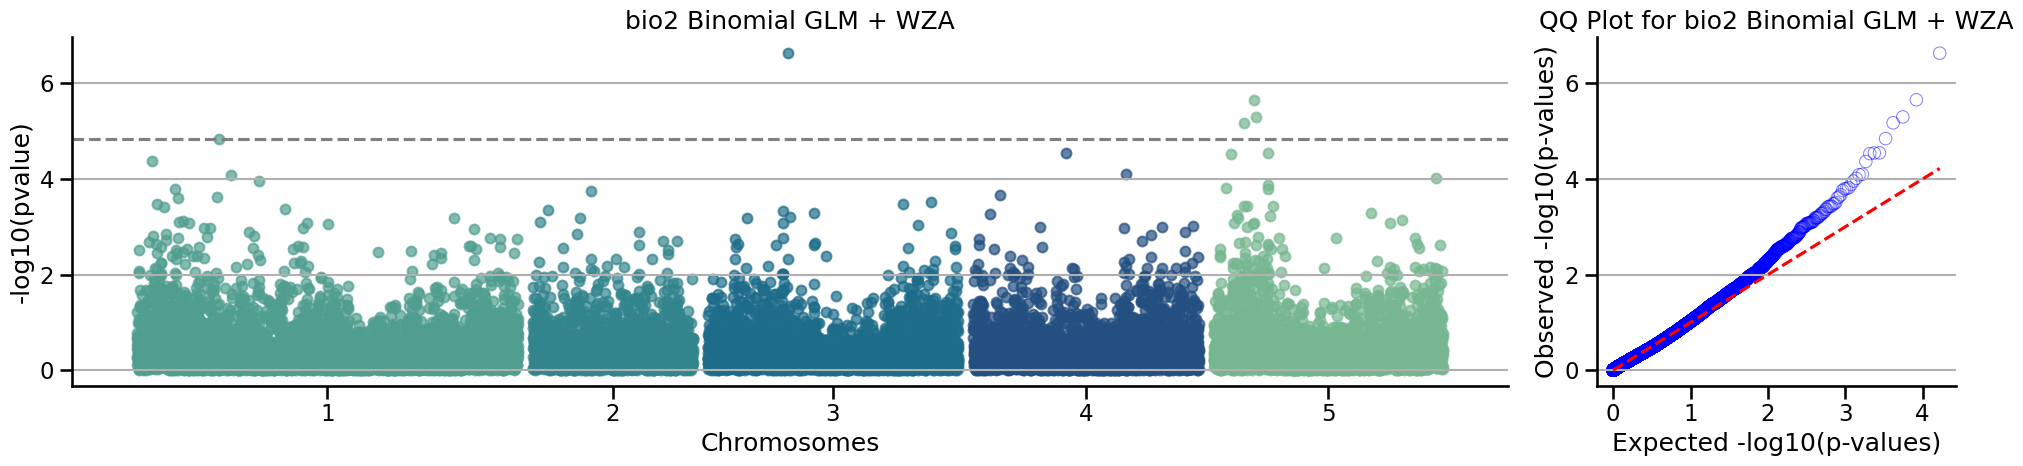

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


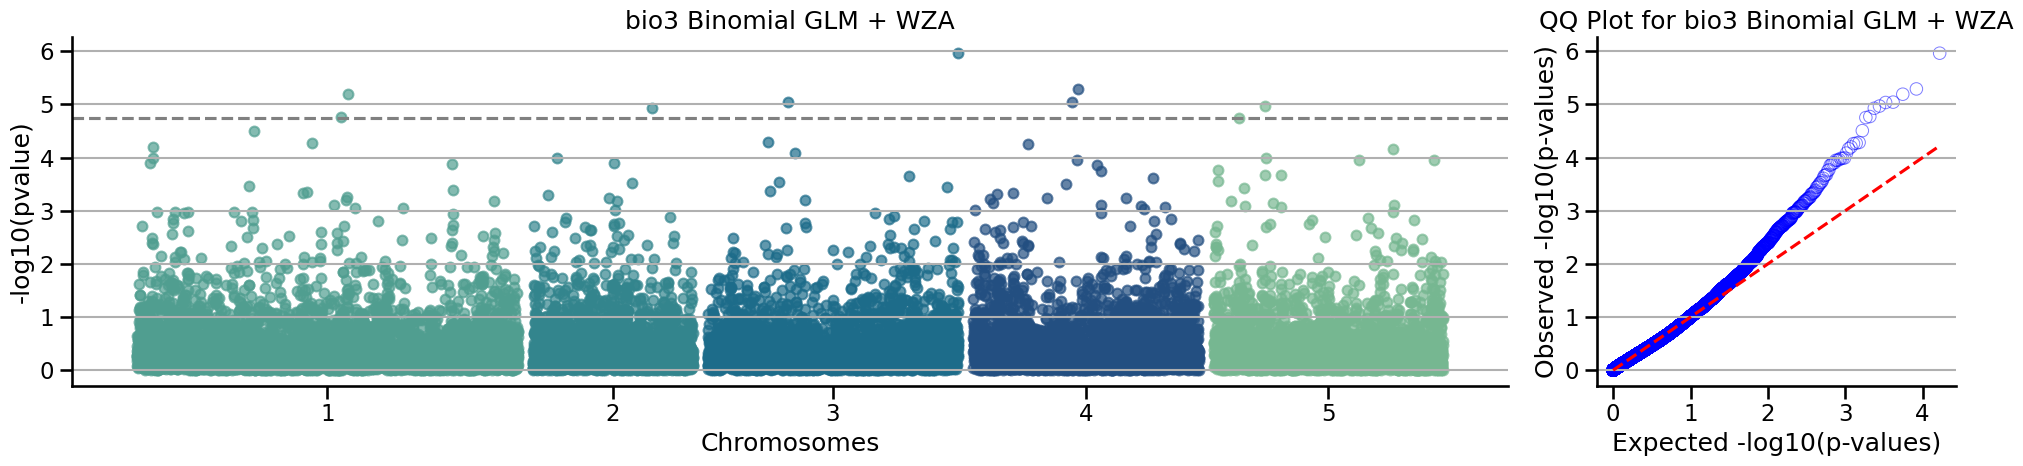

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


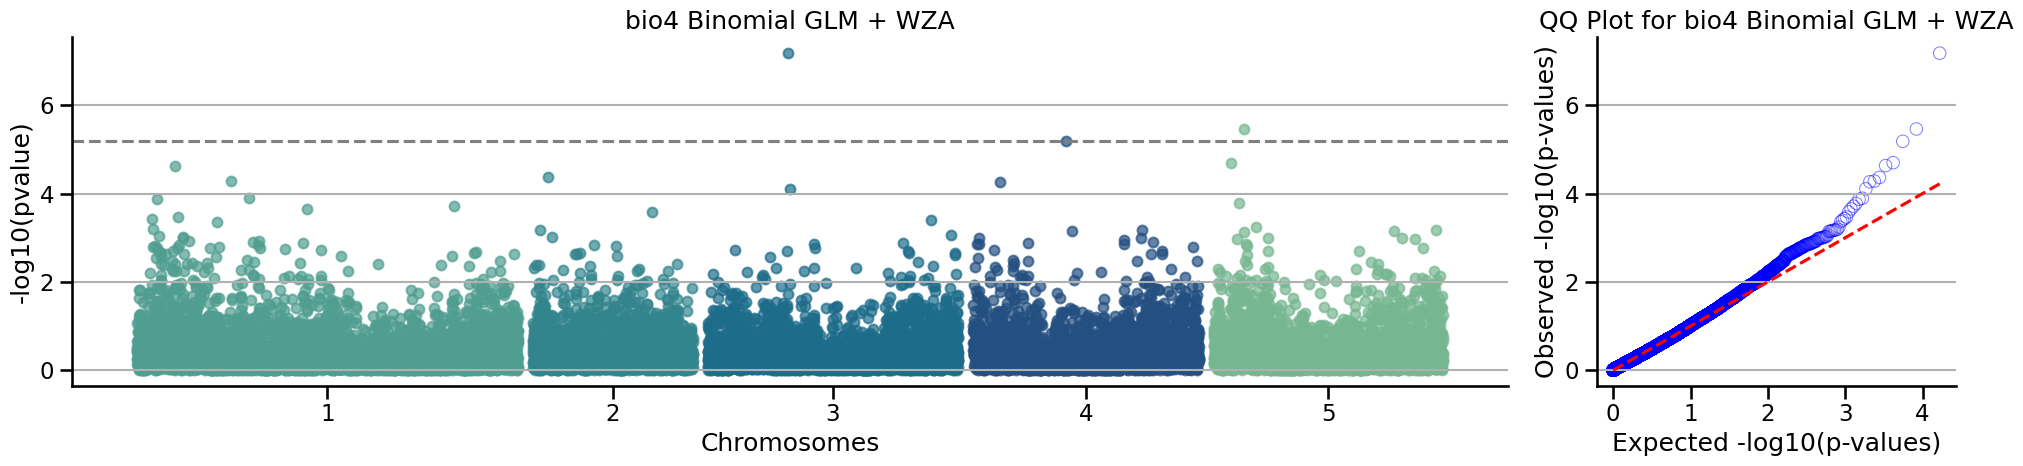

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


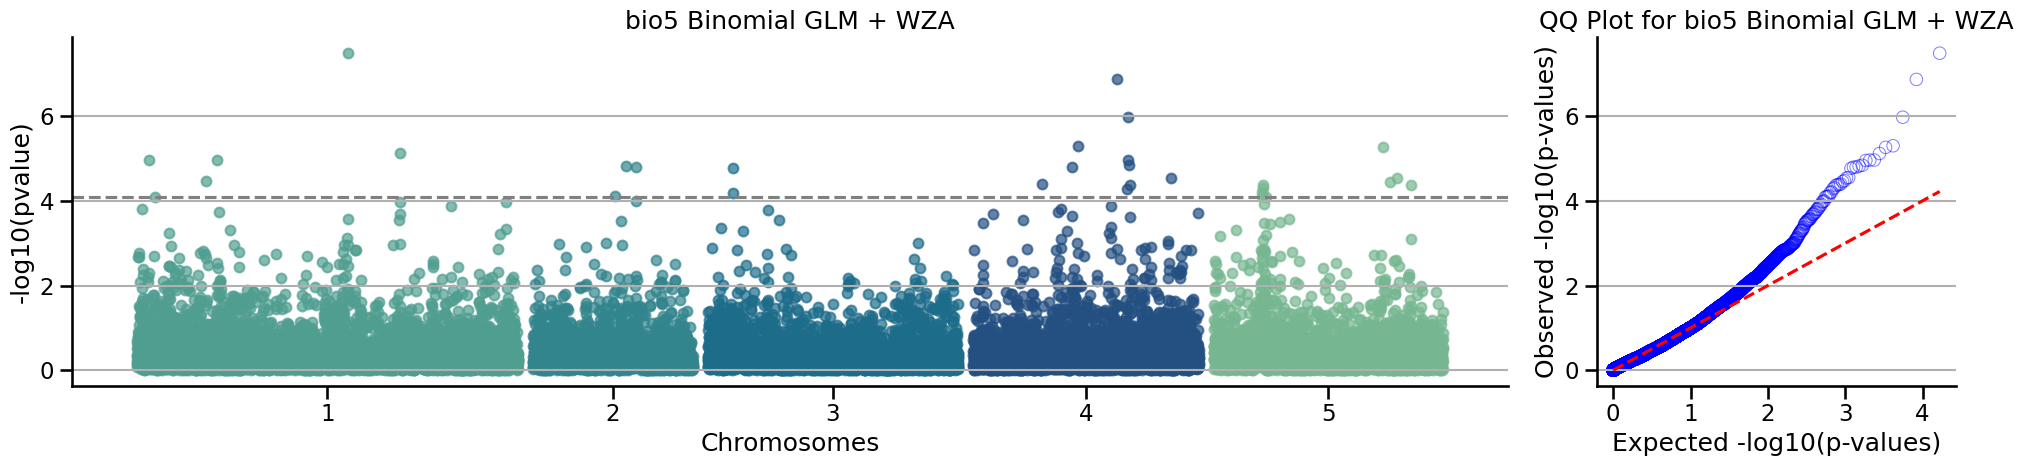

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


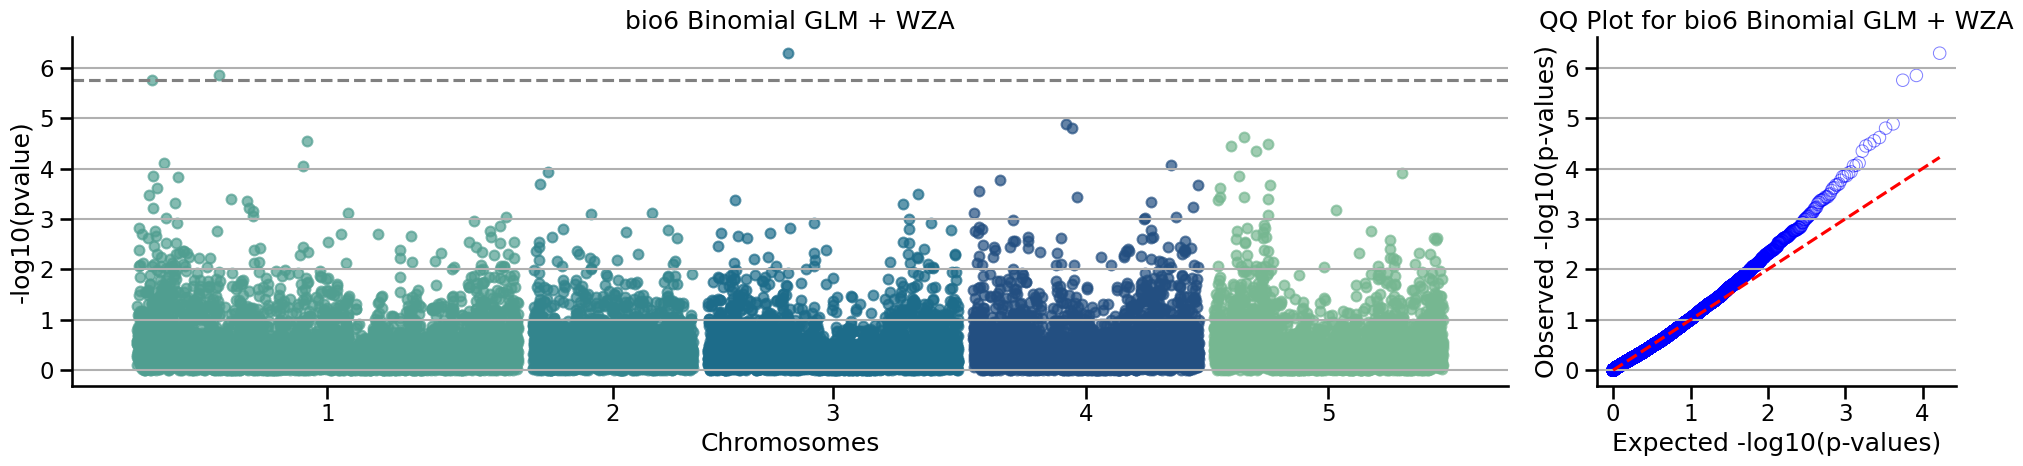

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


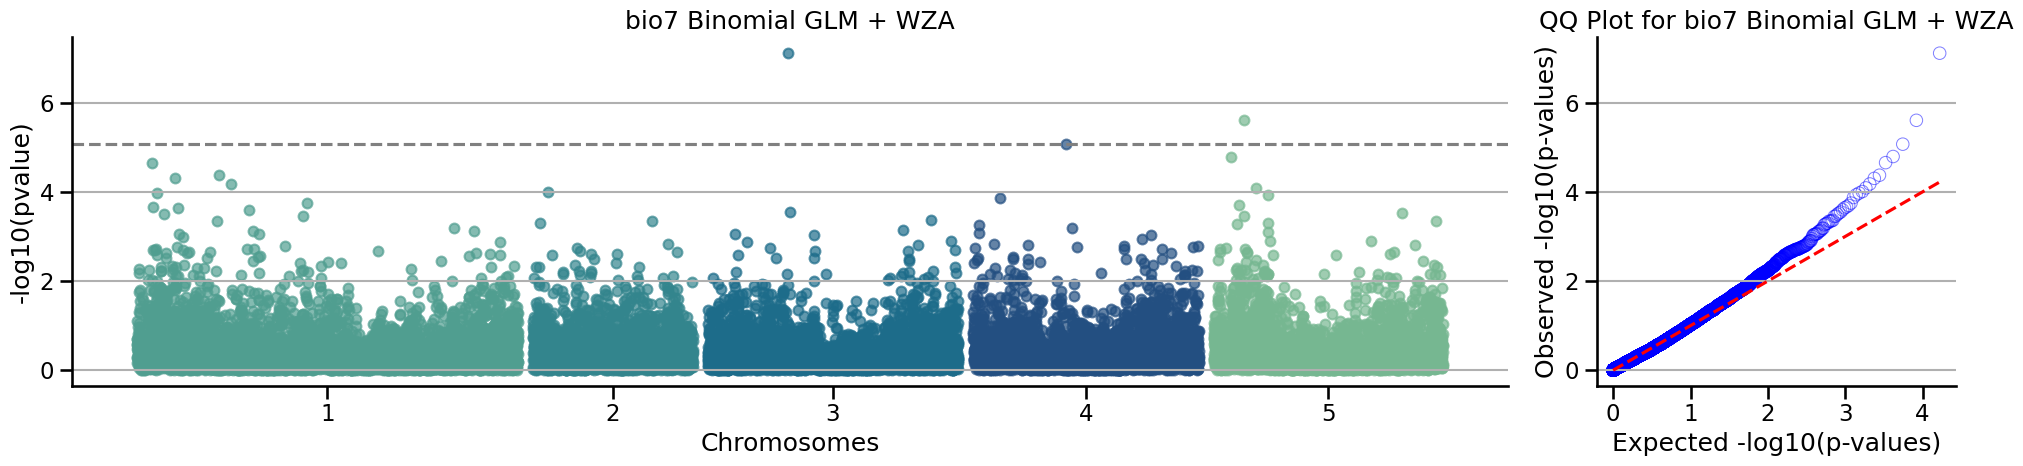

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


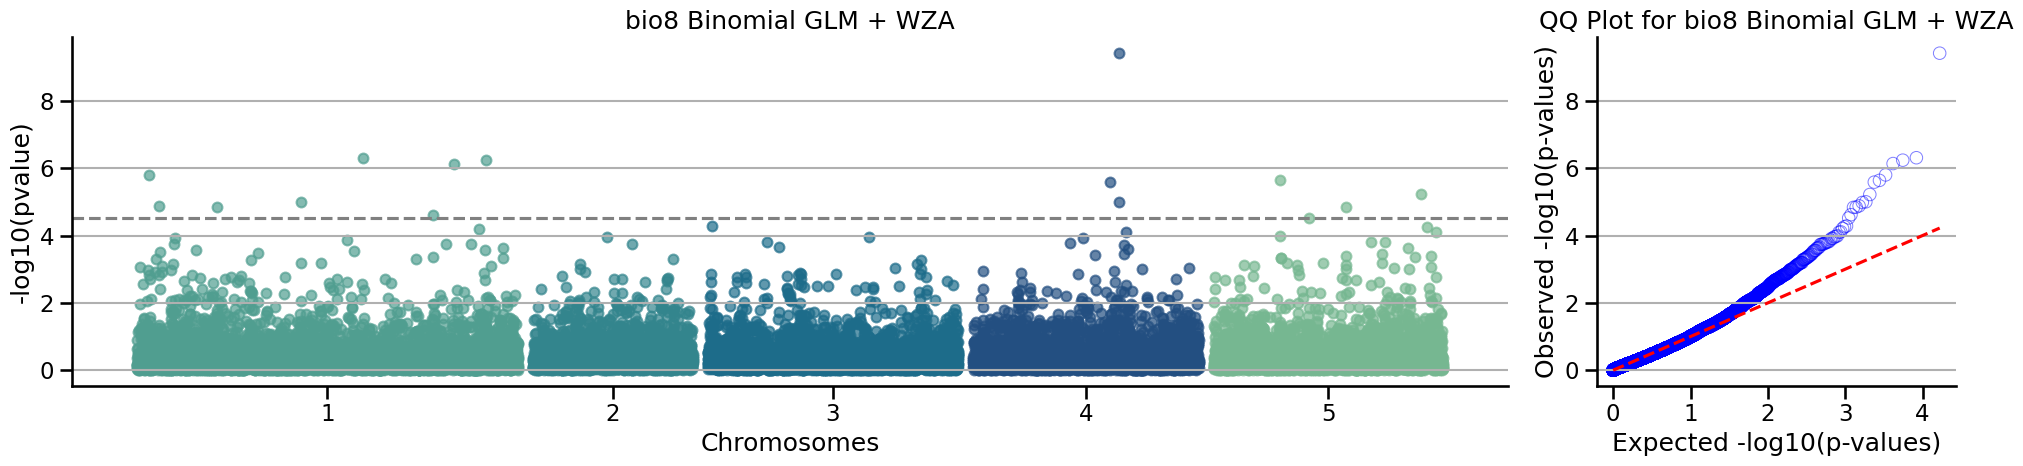

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


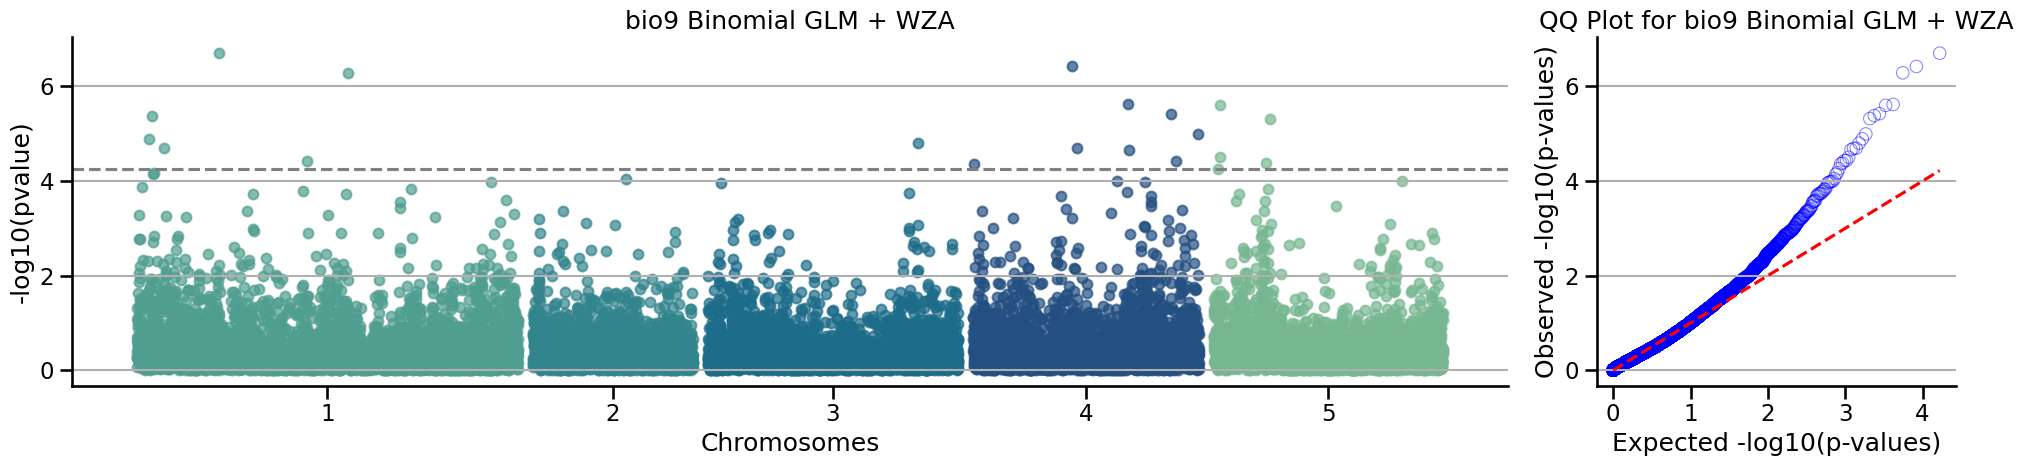

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


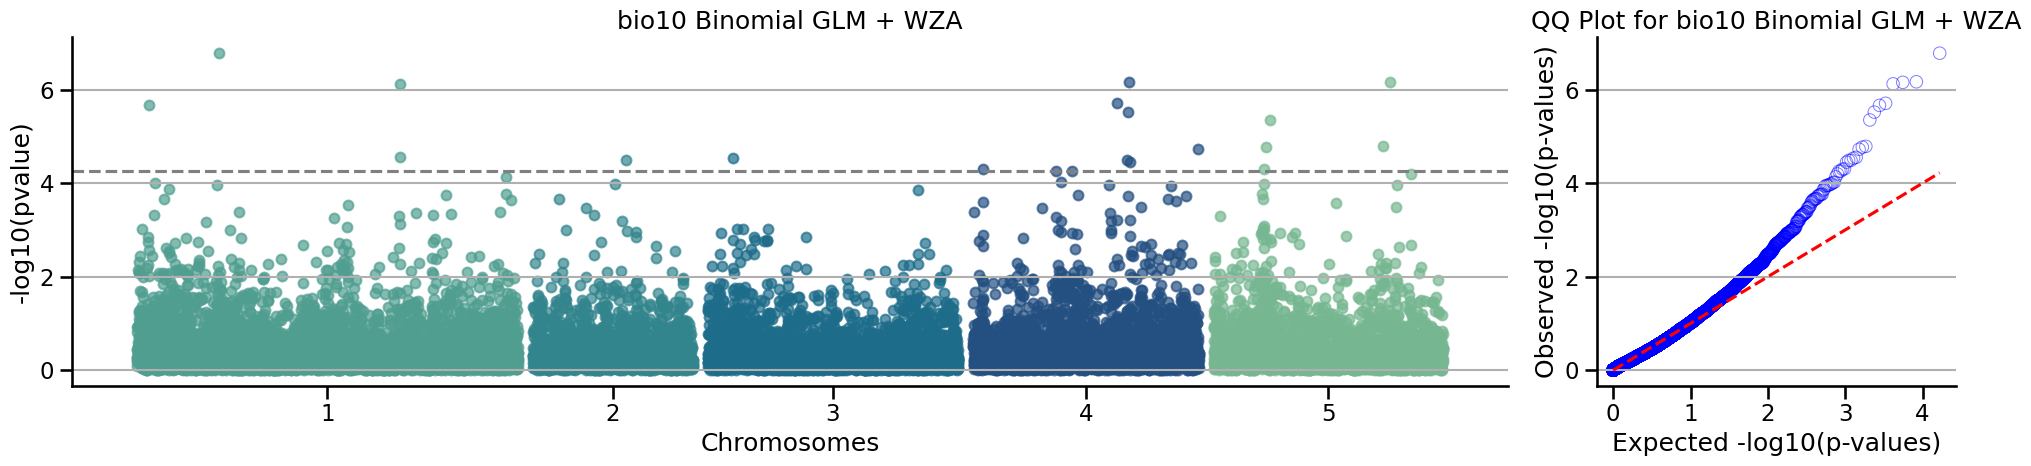

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


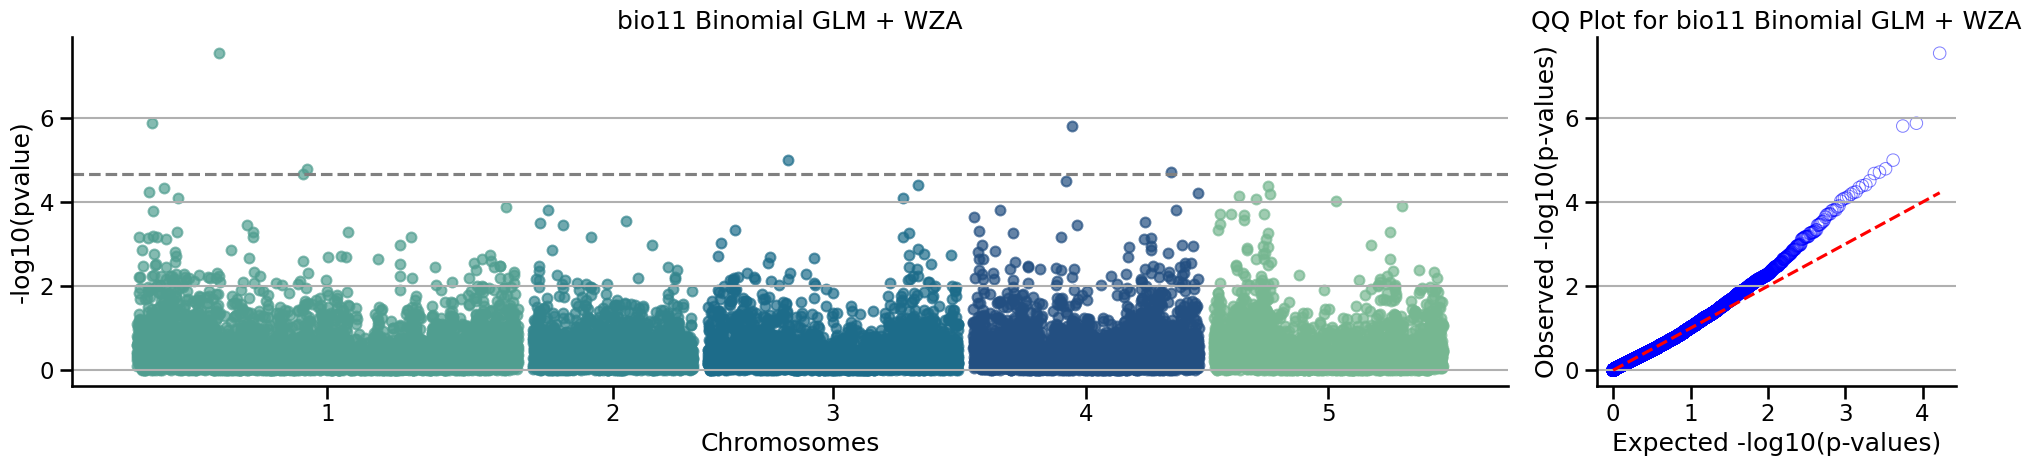

/tmp/ipykernel_1924663/2867150902.py:8: RuntimeWarning: divide by zero encountered in log10
  observed_quantiles = -np.log10(np.sort(wza['Z_pVal'].values))
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


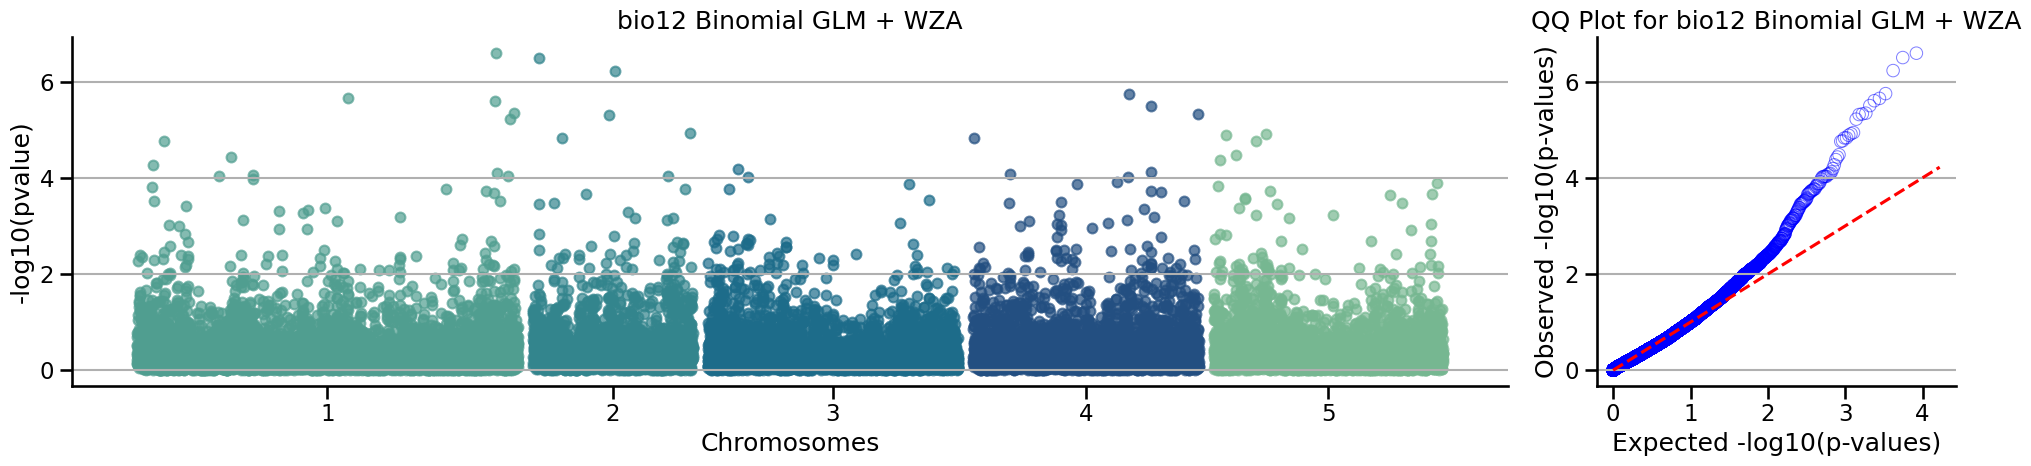

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


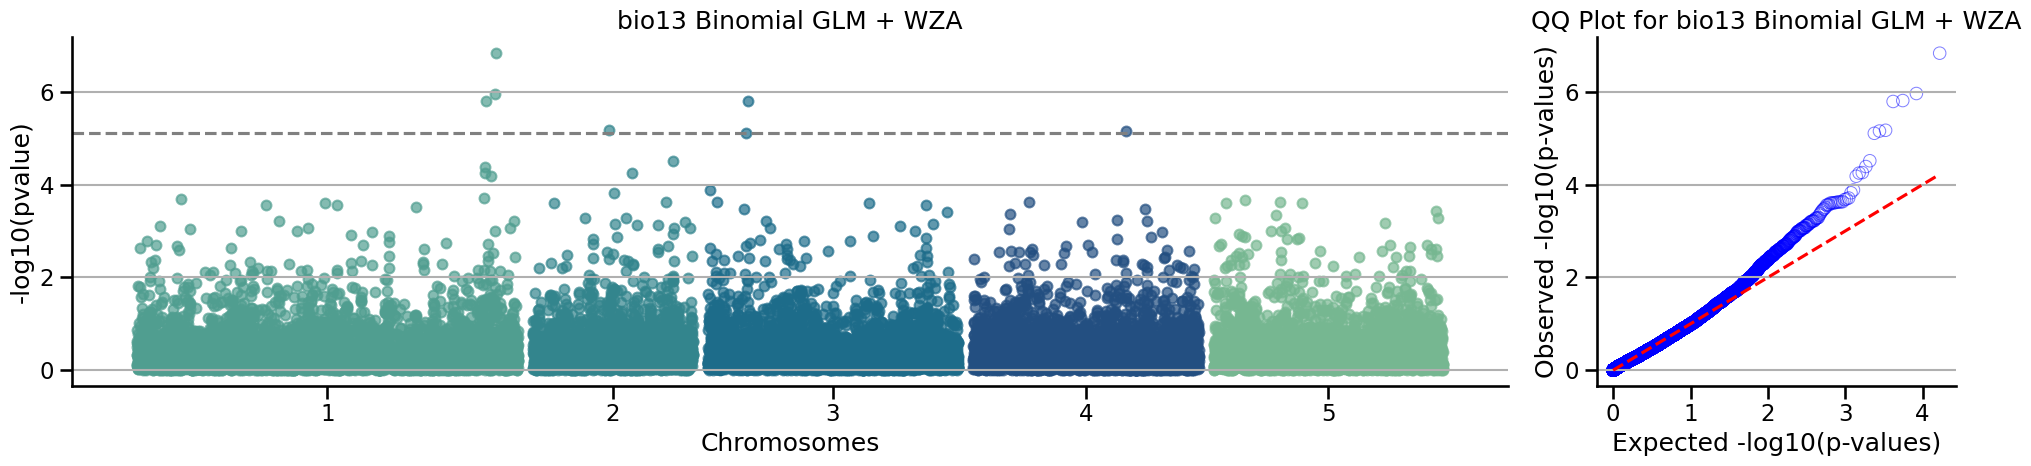

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


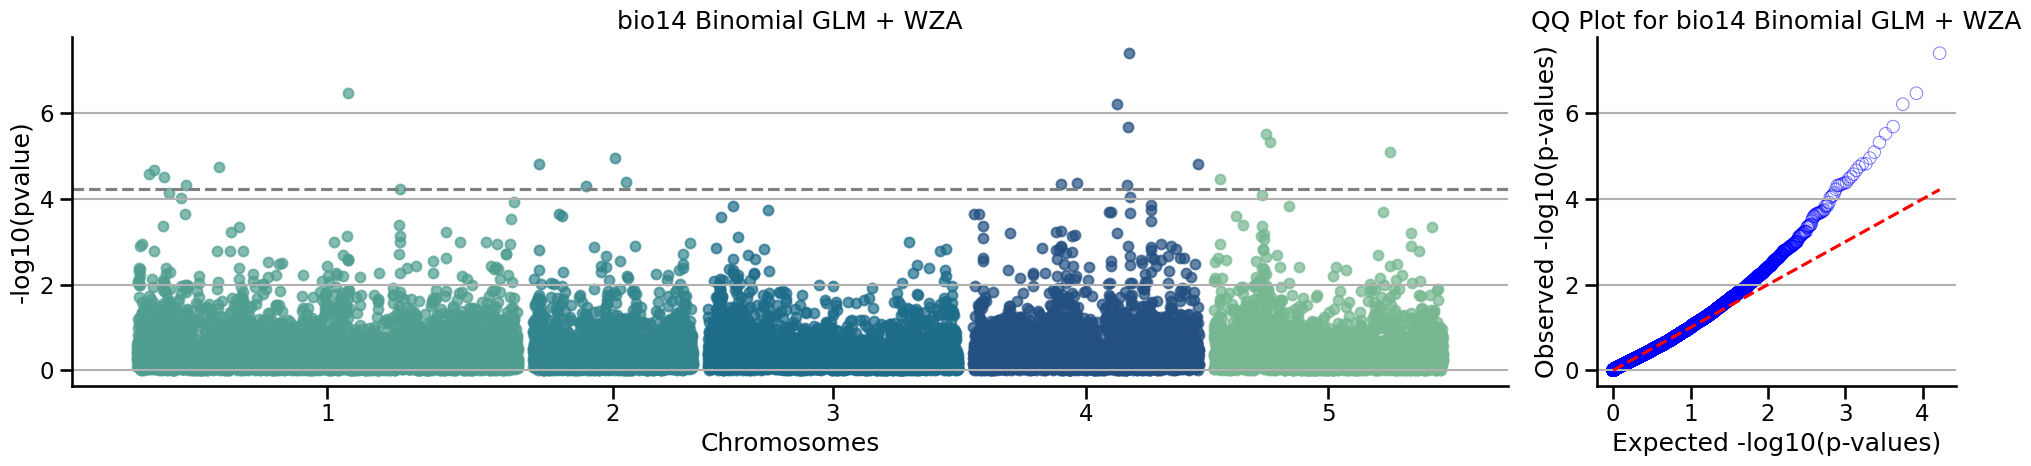

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


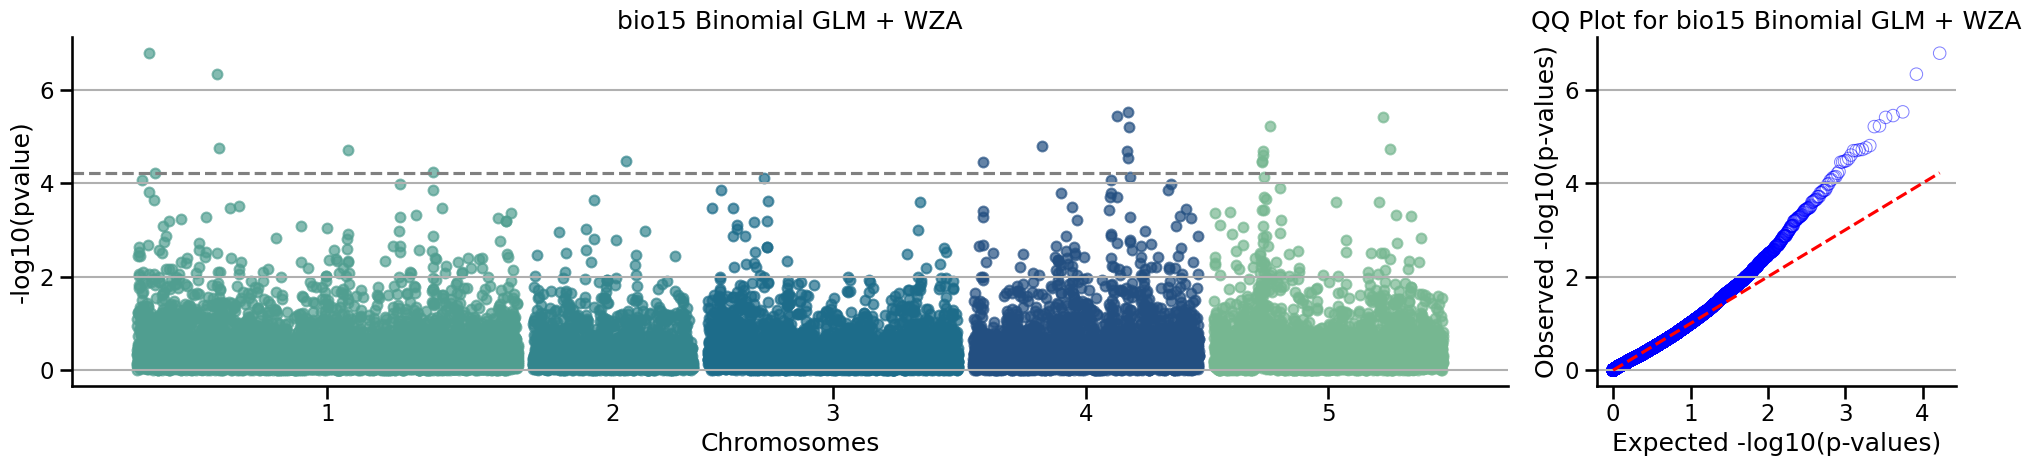

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


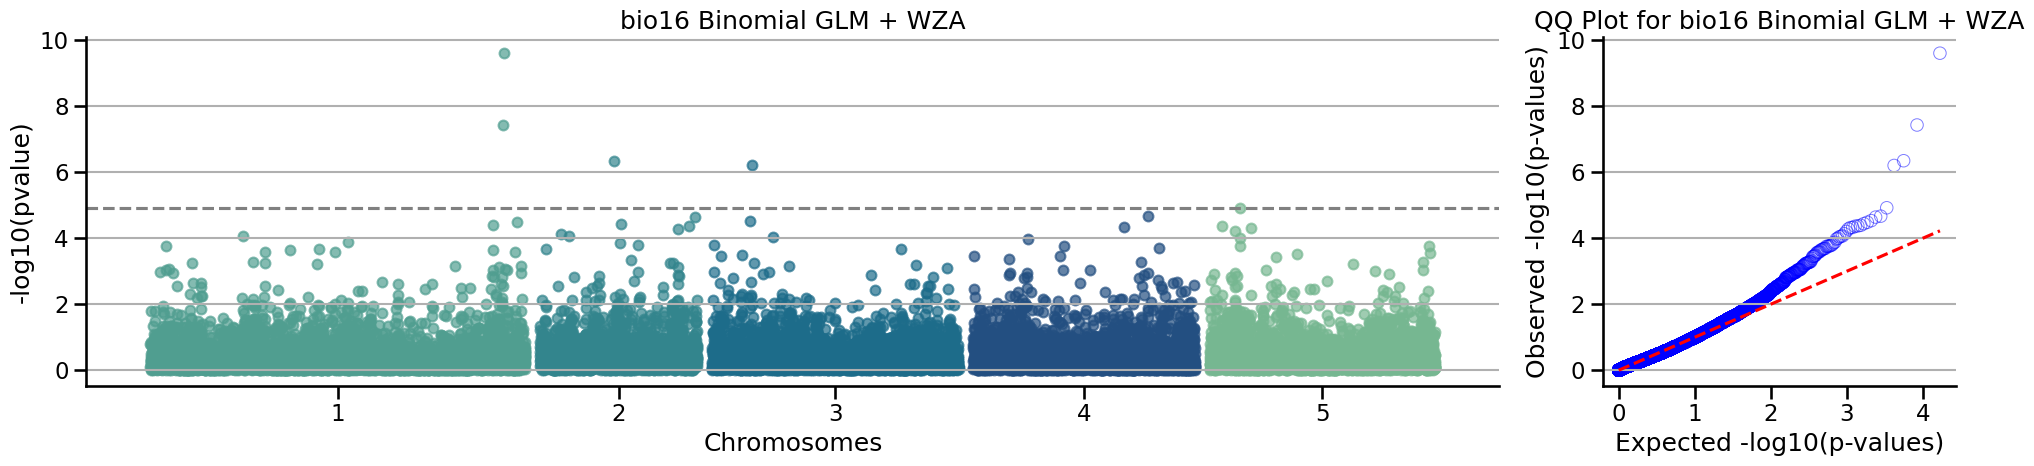

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


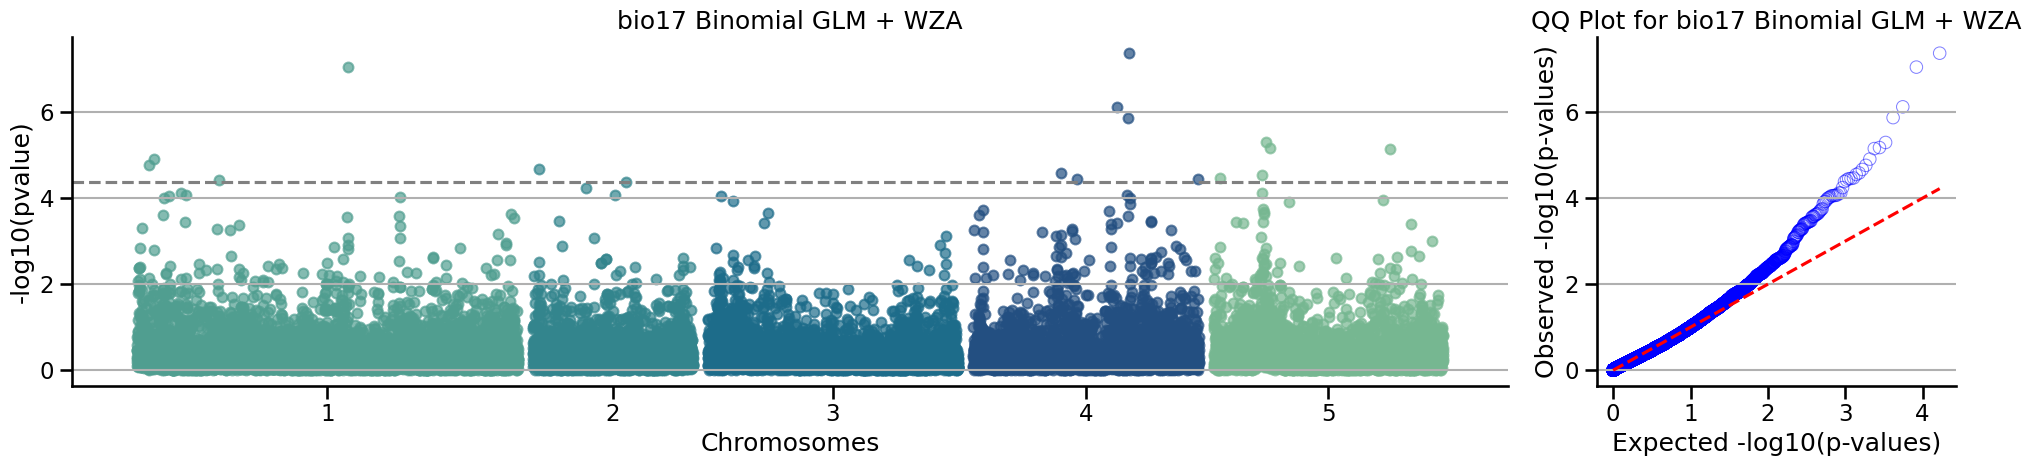

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


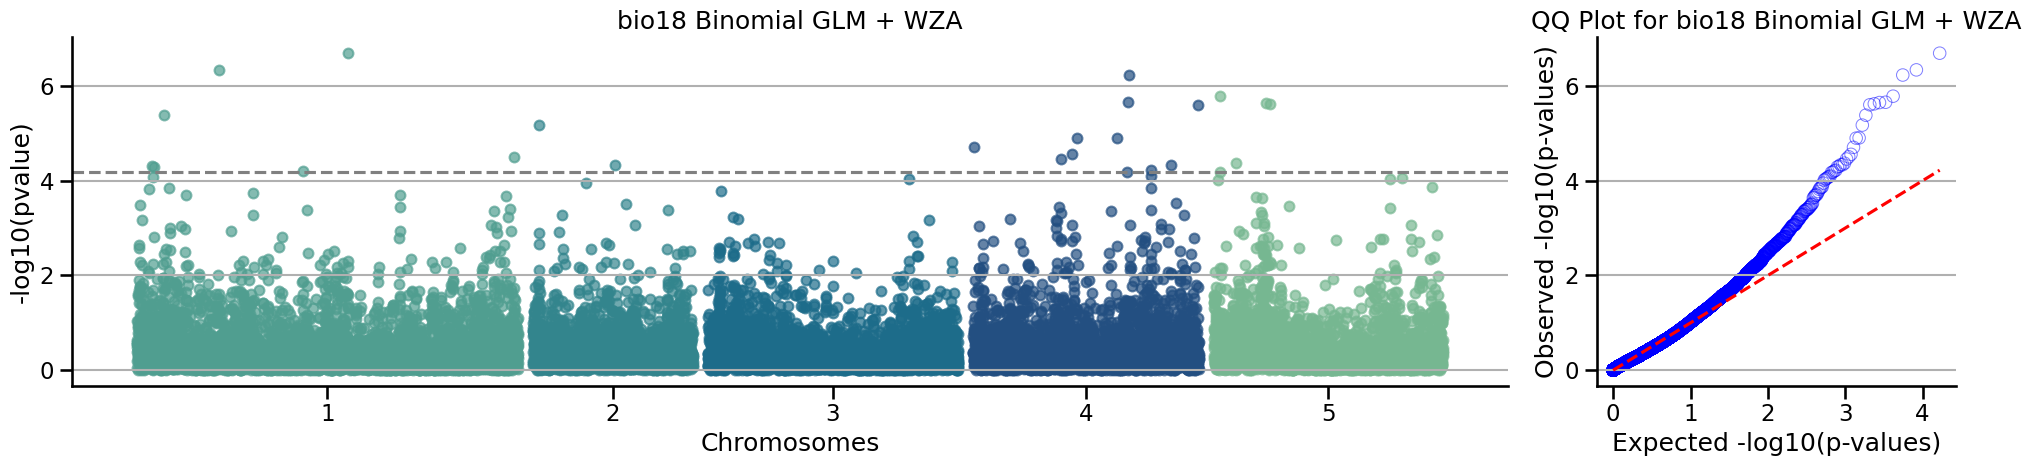

/tmp/ipykernel_1924663/2867150902.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(


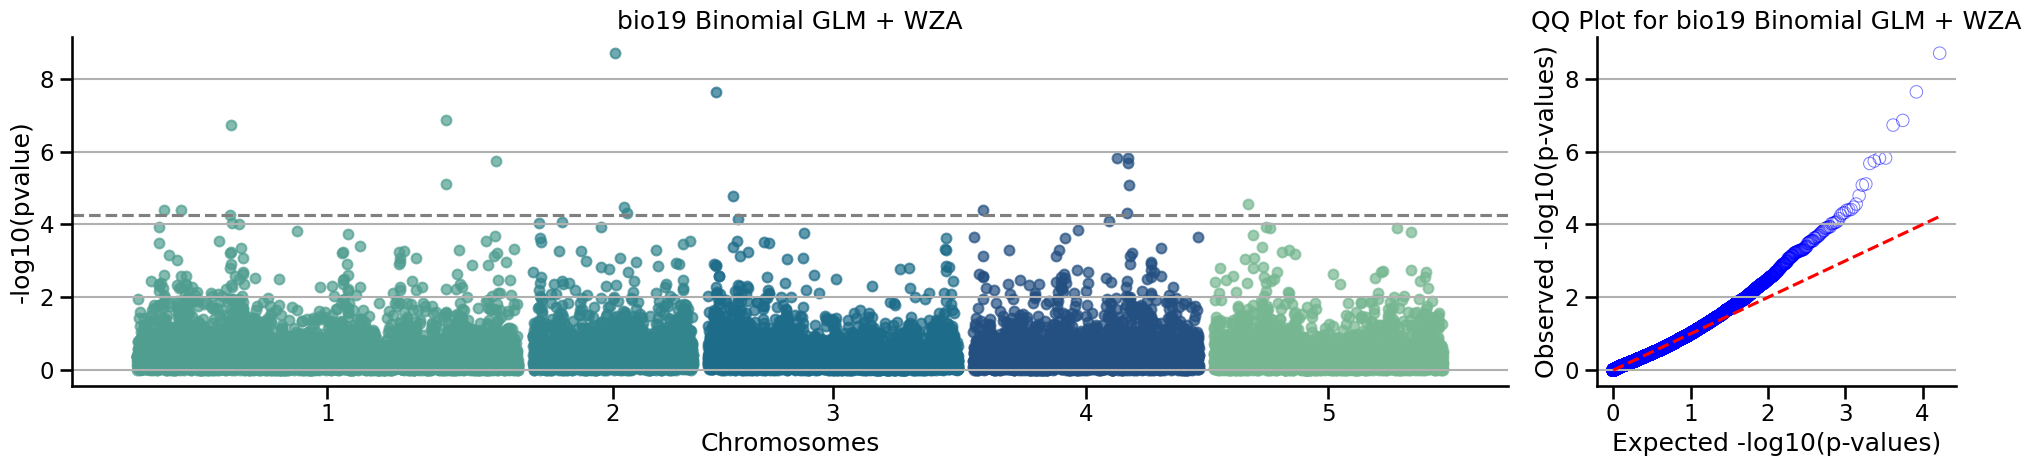

In [81]:
for biovar in biovars:
    wza = pd.read_csv(f'wza_binomial_regression_{biovar}_poly7.csv')

    wza['chrom'] = wza['gene'].str.split('_').str[0].astype(int)
    wza['pos'] = wza['gene'].str.split('_').str[1].astype(int)
    # Assuming 'wza' and 'biovar' are defined and properly set up as needed for your plots
    # Data preparation and calculations
    observed_quantiles = -np.log10(np.sort(wza['Z_pVal'].values))
    expected_quantiles = -np.log10(np.linspace(1 / len(wza), 1, len(wza)))
    #threshold_value = 0.05 / len(wza)
    # Apply Benjamini-Hochberg correction and find critical p-value
    _, adjusted_pvals, _, _ = multipletests(wza['Z_pVal'], alpha=0.05, method='fdr_bh')
    wza['adjusted_pval'] = adjusted_pvals

    # Find the largest raw p-value that corresponds to an adjusted p-value less than or equal to the FDR threshold
    critical_pvalue = wza.loc[wza['adjusted_pval'] <= 0.05, 'Z_pVal'].max()
    #significance_line = all[all['Bonferroni_corrected_pval'] < 0.05]['-log10(pvalue)'].min()
    # DataFrame setup for the Manhattan plot
    df = wza[['Z_pVal', 'pos', 'chrom']].copy()
    df['chromosome'] = df['chrom']
    df['position'] = df['pos']
    df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])
    
    # Color setup
    colors = sns.color_palette("crest", n_colors=5)
    
    # Calculate chromosome offsets as before
    chromosome_offsets = {}
    offset = 0
    chrom_ends = {}
    for chrom in sorted(wza['chrom'].unique()):
        chromosome_offsets[chrom] = offset
        max_position = wza[wza['chrom'] == chrom]['pos'].max()
        offset += max_position + 200
        chrom_ends[offset] = (chrom, max_position)
    
    # Plotting as before
    # ...
    df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)
    
    # Create a figure with custom subplot widths
    fig = plt.figure(figsize=(20, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])  # 80% to 20% width ratio
    
    # Manhattan plot on the first subplot
    ax1 = plt.subplot(gs[0])
    for chrom in sorted(df['chromosome'].unique()):
        subset = df[df['chromosome'] == chrom]
        ax1.scatter(
            subset['adjusted_position'],
            subset['-log10(pvalue)'],
            alpha=0.7,
            c=colors[chrom % len(colors)],
            s=50
        )
    
    ax1.set_xlabel('Chromosomes')
    ax1.set_ylabel('-log10(pvalue)')
    ax1.set_title(f'{biovar} Binomial GLM + WZA')

    ax1.axhline(y=-np.log10(critical_pvalue), color='grey', linestyle='dashed')

    #ax1.axhline(y=-np.log10(threshold_value), color='grey', linestyle='dashed')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.grid(axis='y')
    
    # QQ plot on the second subplot
    ax2 = plt.subplot(gs[1])
    sns.scatterplot(x=expected_quantiles, y=observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5, ax=ax2)
    ax2.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')
    ax2.set_xlabel("Expected -log10(p-values)")
    ax2.set_ylabel("Observed -log10(p-values)")
    ax2.set_title(f'QQ Plot for {biovar} Binomial GLM + WZA')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.grid(axis='y')
        
    # Custom function to determine actual genomic positions from adjusted positions
    def get_original_position(adjusted_pos):
        for end in sorted(chrom_ends.keys()):
            if adjusted_pos <= end:
                chrom, max_pos = chrom_ends[end]
                return f"{chrom}"
        return ""
    
    # Setting the ticks on the Manhattan plot to show actual genomic positions
    ax1.set_xticks([chromosome_offsets[chrom] + wza[wza['chrom'] == chrom]['pos'].max()/2 for chrom in sorted(wza['chrom'].unique())])  # Set ticks at the middle of each chromosome segment
    ax1.set_xticklabels([get_original_position(chromosome_offsets[chrom] + wza[wza['chrom'] == chrom]['pos'].max()/2) for chrom in sorted(wza['chrom'].unique())],)  # Use the function to get original positions as labels
    
    plt.tight_layout()
    plt.savefig(f'last_gen_{biovar}_GLMbinomWZA.png')
    plt.show()

In [ ]:
#genes = ['2_199', '3_2730', '5_2244']
genes = ['2_1265']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}'
        )

In [ ]:
#genes = ['2_199', '3_2730', '5_2244']
genes = ['2_1265', '4_801']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}'
        )

/tmp/ipykernel_3175312/1489910986.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


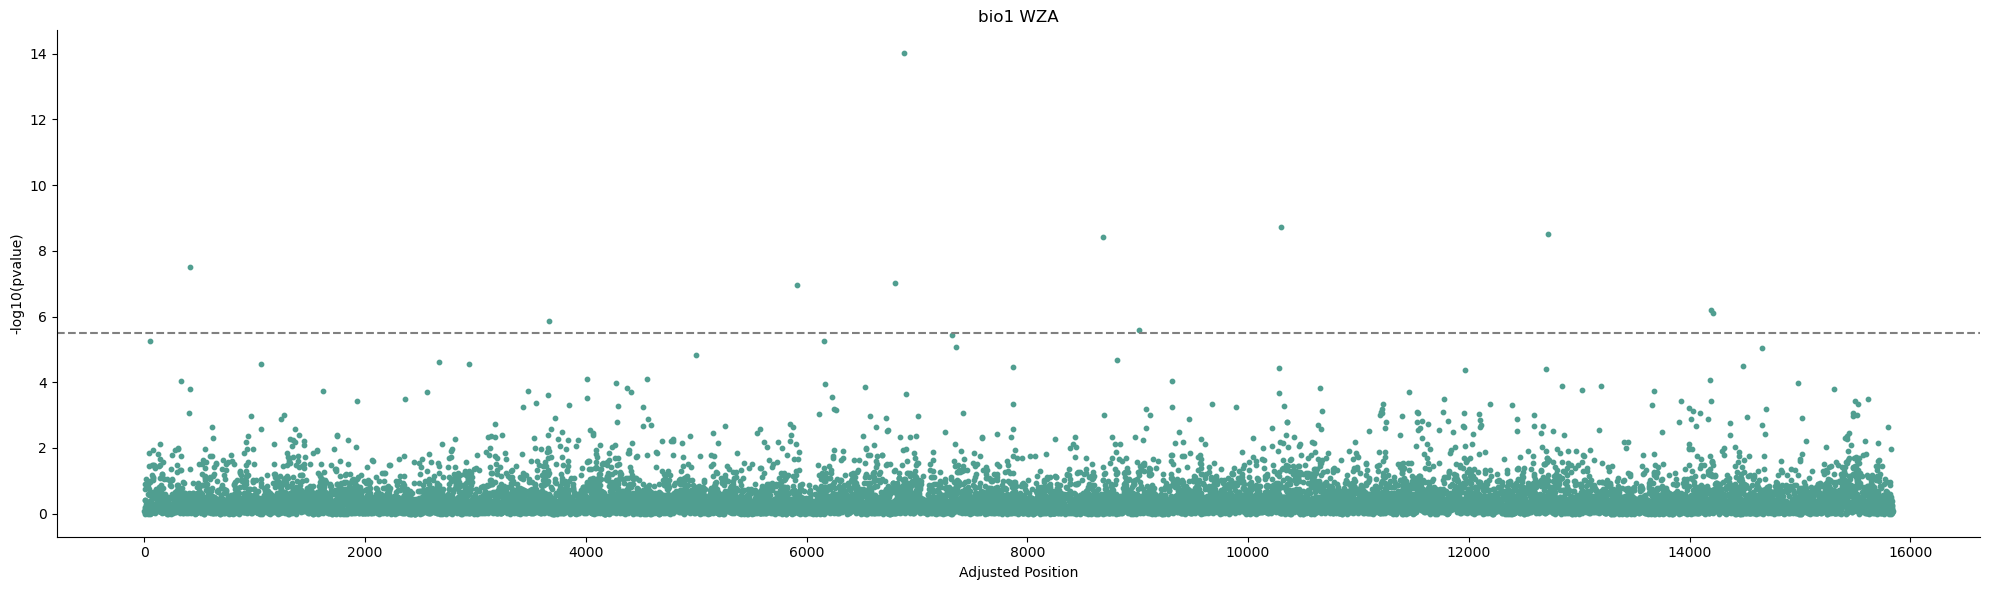

In [54]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['Z_pVal', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
#plt.savefig(f'manhattan_{biovar}.png')
plt.show()

/tmp/ipykernel_3175312/2368688080.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


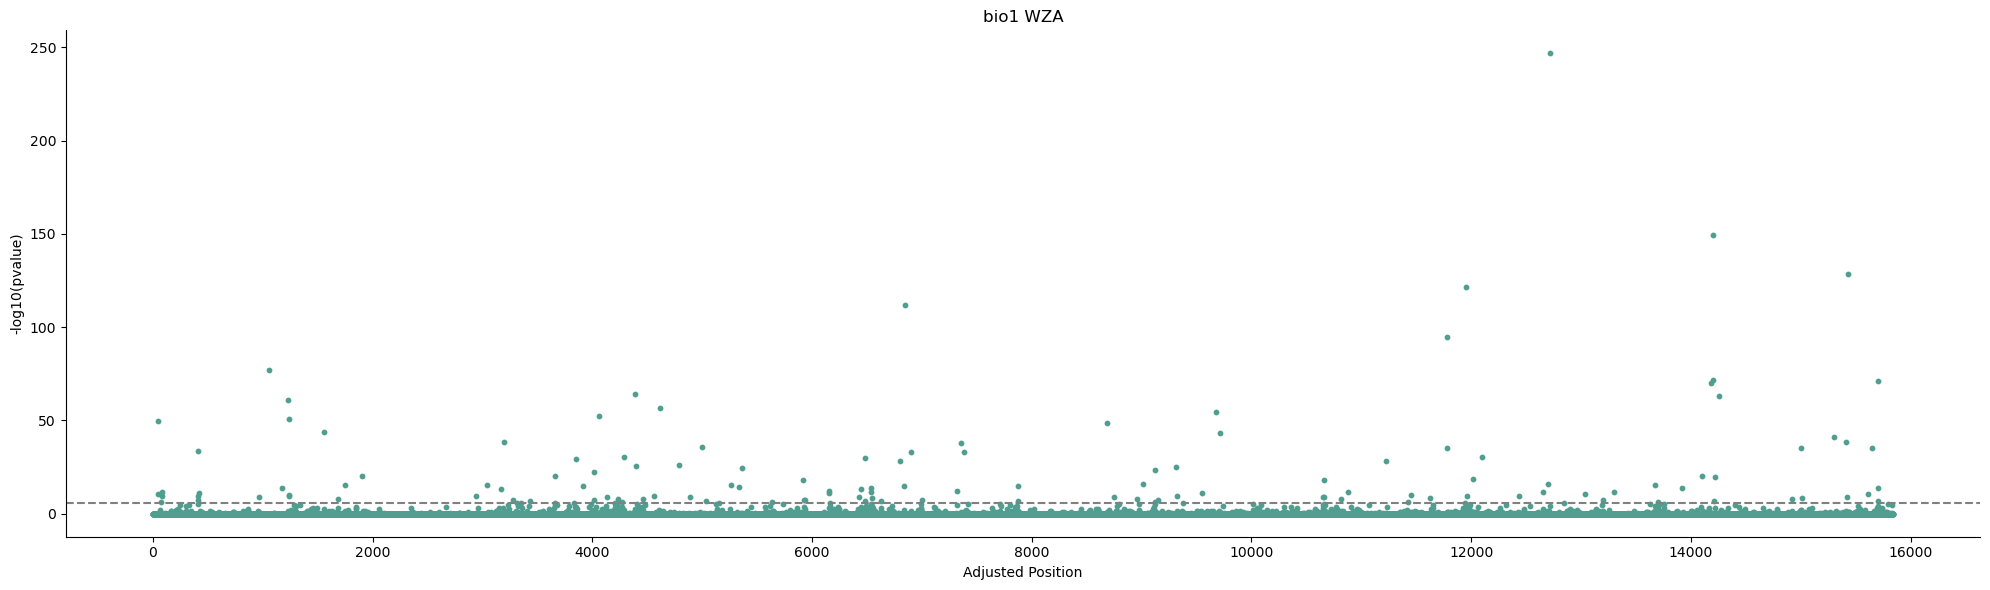

In [50]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['top_candidate_p', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['top_candidate_p'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
plt.savefig(f'manhattan_{biovar}.png')
plt.show()